In [2]:
import constants

import csv
import seaborn as sns
import pandas as pd
import numpy as np

sns.set_context(constants.sns_context)
sns.set_style(constants.sns_style)
data_dir = "/home/cadel/projects/thesis/UNSWThesis/data/perf"
christley_dir = "/home/cadel/docs/code/deduce/data/christley"

## Utilities to run dedUCE programatically

In [2]:
import re
import datetime

def parse_time_v_output(err):
    wall_s = re.findall("Elapsed \(wall clock\) time \(h:mm:ss or m:ss\): (.*)", err)[0]
    min_s, rest_s = wall_s.split(":")
    seconds_s, ms_s = rest_s.split(".")
    walltime = float(min_s) * 60 + float(seconds_s) + (float(ms_s) * 10 / 1000)

    max_rss_kb = float(re.findall("Maximum resident set size \(kbytes\): (.*)", err)[0])
    
    n_uces = int(re.findall("save (\d+) UCEs in fasta format", err)[0])

    
    return {"walltime_seconds": walltime, "max_mem_kb": max_rss_kb, "n_uces": n_uces}

In [5]:
import tempfile
import os
import shutil
import subprocess

DEFAULT_HEADERS = ["walltime_seconds", "max_mem_kb", "n_uces"]

DEFAULT_PARAMS = [
    "--uce-max-occurrences",
    "1000",
    "--uce-min-length",
    "40",
    "--mapper",
    "bowtie",
    "--output-format",
    "fasta",
    "--debug",
    "--jf-hash-size", "30M",
    "--reference", "chromosome1"
]

def run_deduce(params, inputs = [os.path.join(christley_dir, "chloroplast.fa"), os.path.join(christley_dir, "chromosome1.fa")]):
    with tempfile.TemporaryDirectory() as tmp_path:
        for input_path in inputs:
            shutil.copy(input_path, tmp_path)

        current_wd = os.getcwd()
        os.chdir(tmp_path)

        try:
            p = subprocess.run(
                ["/usr/bin/time", "-v", "/home/cadel/.local/bin/deduce", "find"] + params + [tmp_path],
                check=True,
                capture_output=True
            )
            
            output = parse_time_v_output(p.stderr.decode("utf-8"))
        except subprocess.CalledProcessError as e:
            print(e.stderr)
            raise Exception("Failed")

        finally:
            os.chdir(current_wd)
        
        return output

## Core kmer size vs. performance

In [6]:
def generate_ck_vs_perf():
    results = []

    for ck_size in range(20, 45, 5):
        print(ck_size)
        params = DEFAULT_PARAMS + [
            "--core-kmer-size",
            str(ck_size),
            "--uce-core-min-homology",
            "1",
            "--threads",
            "1"

        ]

        r = run_deduce(params)

        r["core_kmer_size"] = ck_size

        results.append(r)
    
    with open(os.path.join(data_dir, "christley_ck_vs_perf.csv"), "w") as f:
        writer = csv.DictWriter(f, fieldnames=["core_kmer_size"] + DEFAULT_HEADERS)

        writer.writeheader()
        writer.writerows(results)

## Number of threads vs. performance

In [11]:
def generate_threads_vs_perf():
    thread_results = []

    for threads in range(1, 17, 1):
        print(threads)
        params = DEFAULT_PARAMS + [
            "--core-kmer-size",
            "20",
            "--uce-core-min-homology",
            "1",
            "--threads",
            str(threads),

        ]

        r = run_deduce(params)

        r["threads"] = threads

        thread_results.append(r)
    
    with open(os.path.join(data_dir, "christley_threads_vs_perf.csv"), "w") as f:
        writer = csv.DictWriter(f, fieldnames=["threads"] + DEFAULT_HEADERS)

        writer.writeheader()
        writer.writerows(thread_results)

# generate_threads_vs_perf()

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


,threads,walltime_seconds,max_mem_kb,n_uces,dataset
0,1,24.64,155788.0,16,(a)
1,2,17.58,175608.0,16,(a)
2,3,15.57,176336.0,16,(a)
3,4,15.03,179460.0,16,(a)
4,5,12.95,225952.0,16,(a)
5,6,12.64,230280.0,16,(a)
6,7,12.20,181012.0,16,(a)
7,8,12.27,185704.0,16,(a)
8,9,15.80,190636.0,16,(a)
9,10,13.26,194996.0,16,(a)


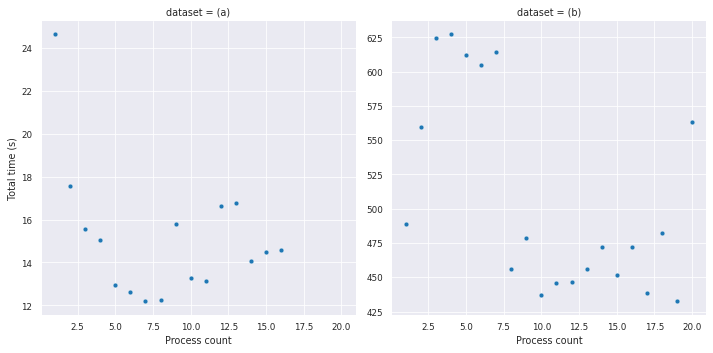

In [37]:
christley_threads_vs_perf = pd.read_csv(os.path.join(data_dir, "christley_threads_vs_perf.csv"))
bej_threads_vs_perf = pd.read_csv(os.path.join(data_dir, "bej_threads_vs_perf.csv"), names=["threads", "walltime_seconds"])

christley_threads_vs_perf["dataset"] = "(a)"
bej_threads_vs_perf["dataset"] = "(b)"

threads_vs_perf = pd.concat([christley_threads_vs_perf,bej_threads_vs_perf],ignore_index=True)


tvp_plot = sns.relplot(data=threads_vs_perf, x="threads", y="walltime_seconds", col="dataset",facet_kws={'sharey': False, 'sharex': True}
)
tvp_plot.set_axis_labels("Process count", "Total time (s)", )
#g.set(xlim=(0, 60), ylim=(0, 12), xticks=[10, 30, 50], yticks=[2, 6, 10])
#g.tight_layout()
tvp_plot.savefig(os.path.join(constants.image_out_dir, "threads_vs_perf.pdf"))
christley_threads_vs_perf

## Homology vs. performance

In [31]:
def generate_homologies_vs_perf_christley(runs = 3):
    for run in range(runs):
        homologies = []

        for homology in range(80,101, 1):
            print(homology)
            params = DEFAULT_PARAMS + [
                "--core-kmer-size",
                "20",
                "--uce-core-min-homology",
                str(float(homology)/100),
            ]

            r = run_deduce(params)

            r["homology"] = float(homology)/100

            homologies.append(r)

            with open(os.path.join(data_dir, "christley_homologies_vs_perf.csv"), "a") as f:
                writer = csv.DictWriter(f, fieldnames=["homology"] + DEFAULT_HEADERS)

                # writer.writeheader()
                writer.writerows(homologies)
                
#generate_homologies_vs_perf_christley()

80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


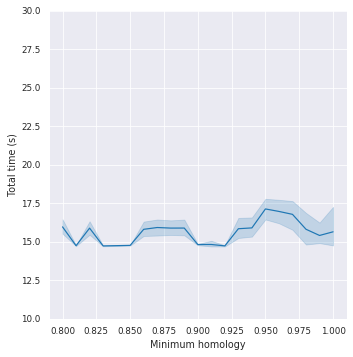

In [32]:
homologies_vs_perf = pd.read_csv(os.path.join(data_dir, "christley_homologies_vs_perf.csv"))

hvp_plot = sns.relplot(data=homologies_vs_perf, x="homology", y="walltime_seconds", kind="line")
hvp_plot.set_axis_labels("Minimum homology", "Total time (s)")
hvp_plot.set(ylim=(10,30))
#hvp_plot.set(xlim=(0, 60), ylim=(0, 12), xticks=[10, 30, 50], yticks=[2, 6, 10])
#g.tight_layout()
hvp_plot.savefig(os.path.join(constants.image_out_dir, "homology_vs_perf.pdf"))

## Performance vs. support level

Using runs of Stephen 2008 genomes with 2,3,4,5 genomes required.

In [9]:
import os
import re
import datetime
from os import listdir
from os.path import isfile, join

ste_path = "/home/cadel/projects/thesis/UNSWThesis/data/perf/support"

ste_files = [f for f in listdir(ste_path) if isfile(join(ste_path, f))]

support_timestamps = {}

for fname in ste_files:
    support = int(fname.split(".")[0][-1])
    
    timestamps = []
    with open(os.path.join(ste_path, fname)) as f:
        for line in f:
            extract = re.findall("^\[(.*)\] \[\d+\] (.*)$", line)
            if len(extract) == 1:
                timestamps.append((
                    datetime.datetime.fromtimestamp(int(extract[0][0].split(":")[-1])),
                    extract[0][1]))
    support_timestamps[support] = timestamps

In [10]:
total_times = {s: ds[-1][0] - ds[0][0] for s, ds in support_timestamps.items()}

In [11]:
stage_triggers = {
    "Core: starting search for core kmers...": "Hashing",
    "Core: reducing hash counts...": "Reducing",
    "Core: intersecting hashes...": "Intersecting",
    "Core: dumping candidates...": "Dumping",
    "Core: aligning candidates...": "Mapping",
    "Candidates: identifying candidate UCEs": "Indexing",
    "Candidates: creating core kmer trie": "Building tries",
    "Candidates: finding UCEs": "Merging",
    "Extension: searching for UCE appearances...": "Extending"
}

def stage_sort_order(s):
    list(stage_triggers.values()).index(s)

def break_down_times_by_stage(timestamps):
    stages = {}
    current_stage = None
    current_stage_t = None
    for t in timestamps:
        if current_stage is None:
            for trigger in stage_triggers.keys():
                if trigger in t[1]:
                    current_stage = stage_triggers[trigger]
                    current_stage_t = t[0]
                    break
        else:
            for trigger in stage_triggers.keys():
                if trigger in t[1] and current_stage != stage_triggers[trigger]:
                    stages[current_stage] = t[0] - current_stage_t
                    current_stage = stage_triggers[trigger]
                    current_stage_t = t[0]
                    break
    
    stages[current_stage] = t[0] - current_stage_t
    return stages

time_breakdowns = {s: break_down_times_by_stage(ts) for s, ts in support_timestamps.items()}

In [12]:
records = [{"support": s, "total_time": total_times[s], **time_breakdowns[s]} for s in support_timestamps]
support_df = pd.DataFrame.from_records(records)

for stage in stage_triggers.values():
    support_df[stage] = [i / j * 100 for i,j in zip(support_df[stage], support_df["total_time"])]
    
support_df["total_time"] = support_df['total_time'] / np.timedelta64(1, 's') / 60
support_df

,support,total_time,Hashing,Reducing,Intersecting,Dumping,Mapping,Indexing,Building tries,Merging,Extending
0,4,167.50,9.482587,14.597015,30.805970,0.019900,19.512438,0.348259,1.691542,22.189055,1.353234
1,3,232.05,4.467428,8.080155,18.975795,0.028729,27.178051,0.409395,2.607197,37.010702,1.242548
2,5,111.60,15.427121,19.459379,44.847670,0.014934,13.157109,0.298686,0.373357,4.540024,1.881720


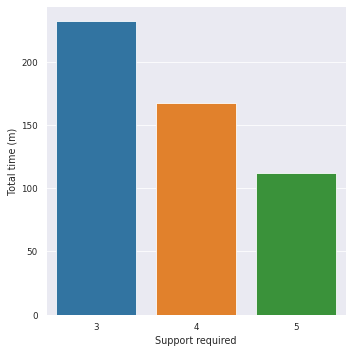

In [13]:
support_plot = sns.catplot(data=support_df, x="support", y="total_time", kind="bar")

support_plot.set_axis_labels("Support required", "Total time (m)")
support_plot.savefig(os.path.join(constants.image_out_dir, "support_vs_perf.pdf"))

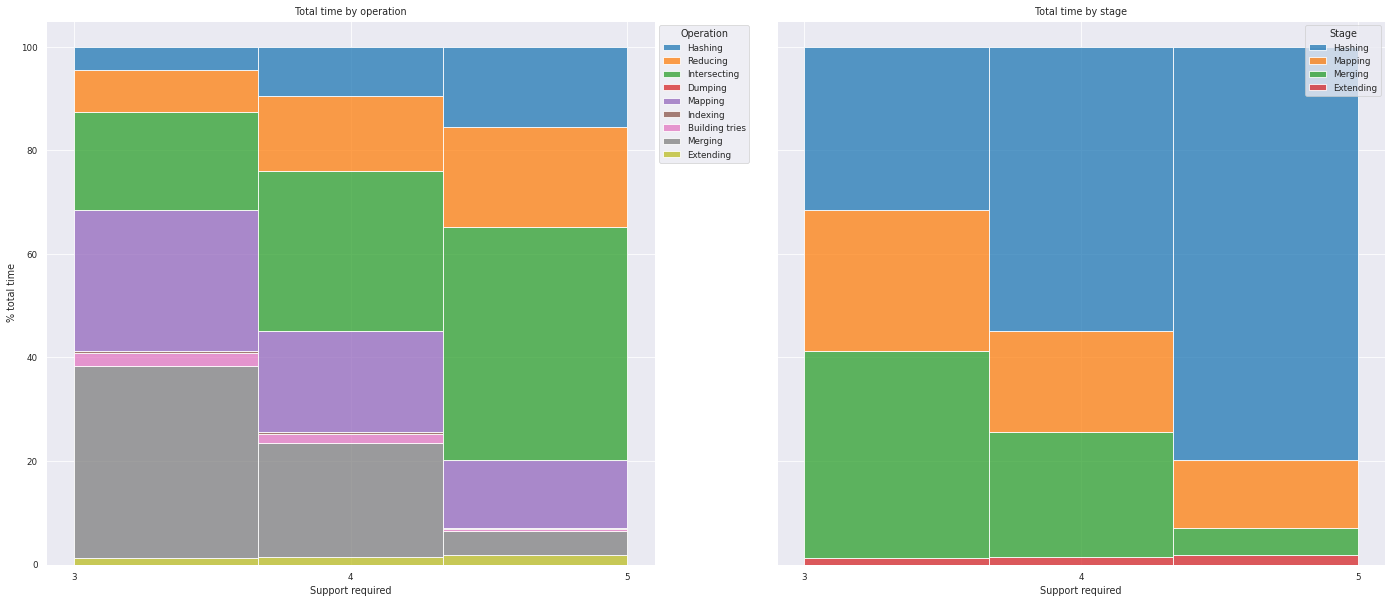

In [14]:
import matplotlib.pyplot as plt 

stage_df = support_df.drop(columns=["total_time"]).melt(id_vars=["support"], var_name="Operation", value_name="Percentage")
stage_df = stage_df.sort_values(by=["Operation"], key=lambda x: x.apply(stage_sort_order))
operation_map = {
    "Hashing": "Hashing",
    "Reducing": "Hashing",
    "Intersecting": "Hashing",
    "Dumping": "Mapping",
    "Mapping": "Mapping",
    "Indexing": "Merging",
    "Building tries": "Merging",
    "Merging": "Merging",
    "Extending": "Extending"
}
stage_df["Stage"] = stage_df["Operation"].apply(lambda x: operation_map[x])

fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(24,10))
ax1.title.set_text("Total time by operation")
ax2.title.set_text("Total time by stage")

stage_plot = sns.histplot(data=stage_df, ax=ax1, x="support", hue="Operation", weights="Percentage", multiple="stack", bins=3)
stage_plot.set_xlabel("Support required")
stage_plot.set_ylabel("% total time")
stage_plot.set_xticks([3,4,5])
legend = stage_plot.get_legend()
legend.set_bbox_to_anchor((1, 1))


op_plot = sns.histplot(data=stage_df, ax=ax2, x="support", hue="Stage", weights="Percentage", multiple="stack", bins=3)

op_plot.set_xlabel("Support required")
op_plot.set_ylabel("% total time")
op_plot.set_xticks([3,4,5])


fig.savefig(os.path.join(constants.image_out_dir, "stage_perf.pdf"))


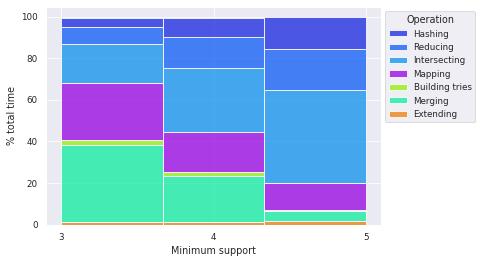

In [31]:
palette = {
    "Hashing": "#1724E0",
    "Reducing": "#0C5AF7",
    "Intersecting": "#0C91ED",
    "Mapping": "#9600E0",
    "Building tries": "#92ED0C",
    "Merging": "#0CED9E",
    "Extending": "#ED7E0C"
}


#c_palette = {}
#for row in stage_df.to_records():
#    c_palette[row[1]] = palettes[palette][row[4]]

op_plot = sns.histplot(data=stage_df[~(stage_df.Operation.isin(["Dumping", "Indexing"]))], x="support", hue="Operation", weights="Percentage", multiple="stack", bins=3, palette=palette)

op_plot.set_xlabel("Minimum support")
op_plot.set_ylabel("% total time")
op_plot.set_xticks([3,4,5])
legend = op_plot.get_legend()
legend.set_bbox_to_anchor((1, 1))

op_plot.get_figure().savefig(os.path.join(constants.image_out_dir, "just_op_perf.pdf"),bbox_extra_artists=(legend,), bbox_inches='tight')

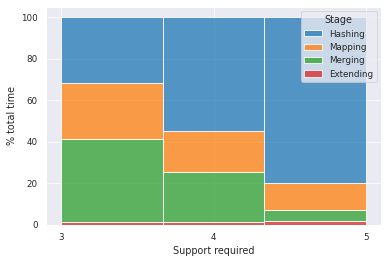

In [18]:
op_plot = sns.histplot(data=stage_df, x="support", hue="Stage", weights="Percentage", multiple="stack", bins=3)

op_plot.set_xlabel("Support required")
op_plot.set_ylabel("% total time")
op_plot.set_xticks([3,4,5])

sns.set_context("talk")

op_plot.get_figure().savefig(os.path.join(constants.image_out_dir, "just_stage_perf.pdf"))

## Performance vs. number of genomes


(0.9392487424262888, 0.0001714140324098114)

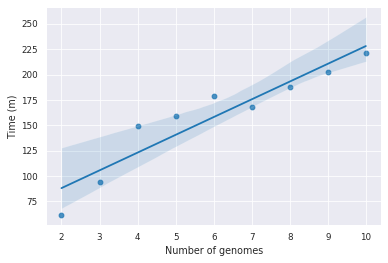

In [8]:
import os
import scipy

ldf = pd.read_csv(os.path.join(data_dir, "linearity", "linearity_runtimes.csv"))

lp = sns.regplot(data=ldf, x="genomes", y="time_m")
lp.set_xlabel("Number of genomes")
lp.set_ylabel("Time (m)")
lp.get_figure().savefig(os.path.join(constants.image_out_dir, "linearity_perf.pdf"))

scipy.stats.pearsonr(ldf.genomes, ldf.time_m)

# ldf.genomes.corr(ldf.time_m)